In [5]:
import numpy as np
import scipy as scp
import scipy.stats as ss
import matplotlib.pyplot as plt
import scipy.special as scps
from scipy.linalg import cholesky
from functools import partial
from scipy.optimize import minimize

from IPython.display import display
import sympy; sympy.init_printing()

def display_matrix(m):
    display(sympy.Matrix(m))

In [6]:
SIZE = 1000000
rho = 0.6

MU = np.array([0, 0])
COV = np.array( [[1, rho], [rho, 1]] ); 
print("COV: "); display_matrix(COV)

Y = ss.multivariate_normal.rvs( mean=MU, cov=COV, size=SIZE )

print("correlation matrix: "); display_matrix(np.corrcoef(Y.T).round(2))

COV: 


⎡1.0  0.6⎤
⎢        ⎥
⎣0.6  1.0⎦

correlation matrix: 


⎡1.0  0.6⎤
⎢        ⎥
⎣0.6  1.0⎦

In [7]:
Y_1 = np.random.normal(loc=0, scale=1, size=SIZE )
Y_2 = rho * Y_1 + np.sqrt(1-rho**2) * np.random.normal(loc=0, scale=1, size=SIZE )
print("correlation matrix: "); display_matrix(np.corrcoef(Y_1,Y_2).round(2))

correlation matrix: 


⎡1.0  0.6⎤
⎢        ⎥
⎣0.6  1.0⎦

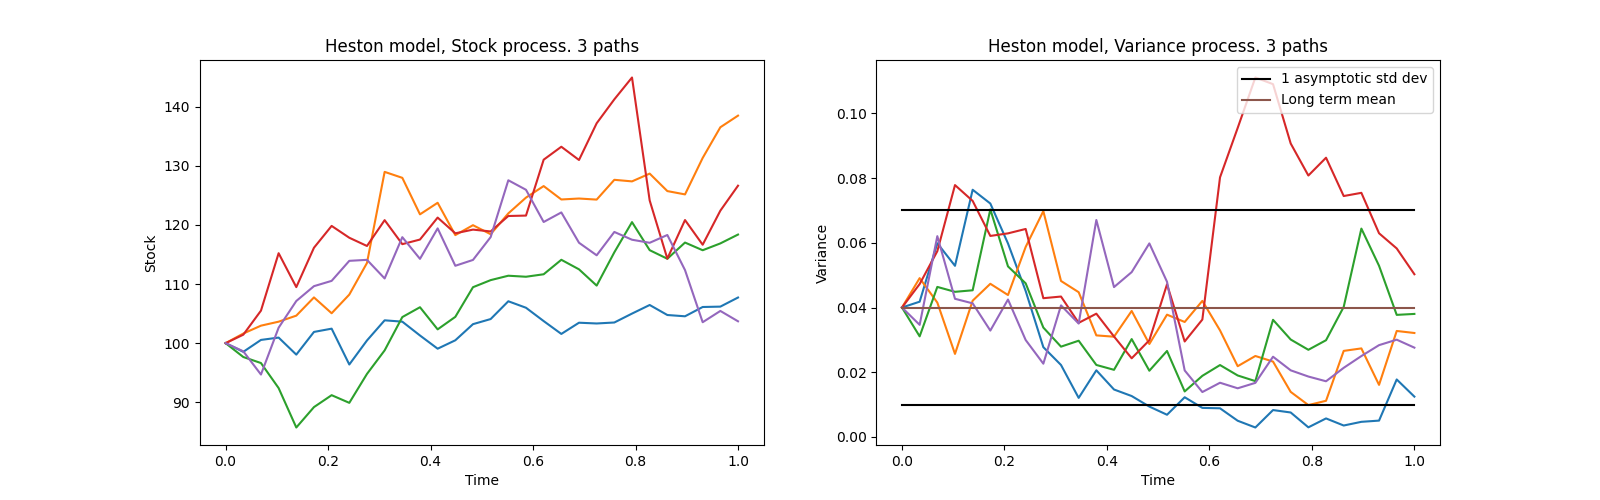

In [81]:
np.random.seed(seed=np.random.randint(0,150))

N = 30                  # time steps 
paths = 5               # number of paths
T = 1
T_vec, dt = np.linspace(0,T,N, retstep=True )
dt_sq = np.sqrt(dt)

S0 = 100          # spot price
X0 = np.log(S0)   # log price
v0 = 0.04         # spot variance
Y0 = np.log(v0)   # log-variance 

mu = 0.1                                           # drift
rho = -0.2                                         # correlation coefficient
kappa = 2                                          # mean reversion coefficient
theta = 0.04                                       # long-term variance
sigma = 0.3                                        # Vol of Vol - Volatility of instantaneous variance
std_asy = np.sqrt( theta * sigma**2 /(2*kappa) )   # asymptotic standard deviation for the CIR process
assert(2*kappa * theta > sigma**2)                 # Feller condition

# Generate random Brownian Motion
MU = np.array([0, 0])
COV = np.matrix([[1, rho], [rho, 1]])
W = ss.multivariate_normal.rvs( mean=MU, cov=COV, size=(paths,N-1) )
W_S = W[:,:,0]   # Stock Brownian motion:     W_1
W_v = W[:,:,1]   # Variance Brownian motion:  W_2

# Initialize vectors
Y = np.zeros((paths,N))
Y[:,0] = Y0
X = np.zeros((paths,N))
X[:,0] = X0
v = np.zeros(N)

# Generate paths
for t in range(0,N-1):
    v = np.exp(Y[:,t])    # variance 
    v_sq = np.sqrt(v)     # square root of variance 
    
    Y[:,t+1] = Y[:,t] + (1/v)*( kappa*(theta - v) - 0.5*sigma**2 )*dt + sigma * (1/v_sq) * dt_sq * W_v[:,t]   
    X[:,t+1] = X[:,t] + (mu - 0.5*v)*dt + v_sq * dt_sq * W_S[:,t]
    
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

ax1.plot(T_vec, np.exp(X.T) )
ax1.set_title("Heston model, Stock process. 3 paths"); ax1.set_xlabel("Time"); ax1.set_ylabel("Stock")
ax2.plot(T_vec, np.exp(Y.T) )
ax2.set_title("Heston model, Variance process. 3 paths"); ax2.set_xlabel("Time"); ax2.set_ylabel("Variance")
ax2.plot(T_vec, (theta + std_asy)*np.ones_like(T_vec), label="1 asymptotic std dev", color="black" )
ax2.plot(T_vec, (theta - std_asy)*np.ones_like(T_vec), color="black" )
ax2.plot(T_vec, theta*np.ones_like(T_vec), label="Long term mean" )
ax2.legend(loc="upper right"); 
plt.show()